# Patent Phrase Alignment Using Large Neural Language Models
#### LING 6300 Project

#### Zhiyong Wang, Karan Praharaj

Besides this notebook, we also provide our pure python code(s) and datasets in this [github repo](https://github.com/ravenouse/Patent_Competition).<br>
The code(s) in the repo is what we used to run experiments formly.

##**Introduction**

Patents are a crucial instrument for the promotion of innovation and technological advancement, and for improving human lives overall. The system of patents is a framework that incentivises the progress of scientific ideas and gives impetus to economic growth and stimulates groundbreaking research and engineering. Patents undergo an intensive vetting process prior to grants. However, U.S. patent archives are diverse, voluminous and have a history that goes back 200 years! Before granting a patent to a prospective inventor, The U.S. Patent and Trademark Office (USPTO) needs to examine the patent application and ensure that the applicant(s) is (are) entitled to it. The main, albeit not the sole, question that governs this decision is whether the intellectual property being claimed by the applicant has been claimed before. This can be a tedious task to do manually, considering the volume of data involved. This is where Machine Learning enters the picture to automate the evaluation of similarities between the patent application and records of previously granted patents. Determining the semantic similarity between phrases in these documents is critically important during the patent examination process. This is the problem we focus on in this work.

This task is an ongoing Kaggle Challenge titled ["U.S. Patent Phrase to Phrase Matching"](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/overview).

**Goal:** Build a model which matches phrases and estimates the semantic similarity between them by accounting for contextual information so as to and aid the examination process.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Patent/us-patent-phrase-to-phrase-matching

/content/drive/MyDrive/Patent/us-patent-phrase-to-phrase-matching


In [ ]:
!pip install wandb
!pip install datasets
!pip install transformers

We import the Weights and Biases library, shortened as [WandB](https://docs.wandb.ai/quickstart), which is a central dashboard platform to keep track of 
hyperparameters, system metrics and predictions so we can compare our models live and monitor training runs.

In [ ]:
import wandb

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
%env WANDB_PROJECT= patent

env: WANDB_PROJECT=patent


To use off-the-shelf pre-trained models, we use the `transformers` library maintained by [HuggingFace🤗](https://https://huggingface.co). The HuggingFace library offers models based on Transformers for PyTorch and TensorFlow 2.0. There are hundreds of pre-trained models available in their library for tasks ranging from sequence classification, information extraction, question answering, summarization etc.

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
import shutil

from torch.utils.data import DataLoader, Dataset
import datasets, transformers
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification, AutoTokenizer

This task extends beyond general semantic similarity and hence is not akin to paraphrase identification. This is because the contextual aspect is crucial in patent phrase matching, and considering the conventional senses of words/concepts is not adequate. For example, the words "remote" and "pandemic" are not semantically similar from a general linguistic standpoint. However, in the context of Covid-19, they would be more similar because of their frequent usage in writing related to the pandemic. Thus, in a task like this, harnessing information pertaining to context is imperative.

Because context is important in our scenario, embedding models like [BERT](https://arxiv.org/pdf/1810.04805.pdf) (Devlin et al, 2019), which generate contextualized embeddings can offer an advantage over models such as Word2Vec, because while each word has a fixed representation under Word2Vec regardless of the context within which the word appears, BERT produces word representations that are dynamically informed by other words occuring in the vicinity. For example, given two sentences: "Please bear with us." and "A bear was spotted in the village.", Word2Vec would provide the identical word embeddings for the word "bear" in both sentences, despite the fact that the word "bear" is a homonym and has two different meanings despite having the same spelling. BERT, on the other hand, is designed to capture this polysemy with context-informed word embeddings which in turn result in better downstream performance.

For these reasons, we opt to choose BERT-based architectures for our project. There is a larger variant of the BERT architecture released by Devlin et al., called [BERT-Large](https://github.com/google-research/bert). This version of BERT is similar to BERT-base, except that it has more attention heads and many more hidden layers, which increases its parameter from 110 million to 340 million parameters. We found that there is a BERT-Large model released by Google specifically pre-trained on patent data (100M+ patents). Even though this pre-training is done on patents from all over the world and not just US patents, this could still provide us a much stronger cold-start as opposed to using the standard BERT. This is the first model tested in our analysis.

However, we must be mindful of the fact that BERT-Large has an extremely large number of parameters, and so it is worth comparing it against a smaller, lighter variant of BERT to analyze the effect of parameterization on the final performance. We use [distillBERT](https://https://arxiv.org/abs/1910.01108) as the second model in our analysis. distillBERT is a smaller, faster and lighter equivalent of BERT released by HuggingFace. The number of parameters in this architecture is 66 million. This model has shown that it is possible to reduce the size of the original BERT model by 40%, while still retaining 97% of its language understanding capabilities. This makes it an interesting candidate model for our purposes.


In summary, we use two variants of BERT:
1) [BERT for Patents](https://https://huggingface.co/anferico/bert-for-patents)
2) [distillBERT](https://https://huggingface.co/docs/transformers/model_doc/distilbert)

In [ ]:
'''Setting the configuration for the model. Considering the large sizes of BERT architectures (regardless of variant), we decide against
carrying out a hyperparameter optimization. In a world where we had access to more computational resources and lesser time constraints, we would 
define a hyperparameter grid space and then conduct a grid-search over it to converge on the best combination of hyperparameters. For now, we either
stick to frequently used hyperparameter values, or pick them arbitrarily based on our judgement. Hand-wavy, but hopefully justified under 
our limited computational budget.'''

class CFG:
    input_path = '/content/drive/MyDrive/Patent/us-patent-phrase-to-phrase-matching/'
    
    learning_rate = 2e-5
    weight_decay = 0.01
    epochs = 10
    batch_size = 16

## **Data**

We use the [data](https://https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/data) provided by the creators of the Kaggle challenge for our training and evaluation. 

The data contains two splits, *train* and *test*. The training set contains phrases, contexts, and their similarity scores. The "context" is the CPC classification, or the subject within which the similarity must be scored. The similarity score is a mean of one or more manual ratings provided by experts.

The training data consists of 36473 examples. The test set provided is actually an auxiliary test set of 36 examples. The actual test set has not been released as it is used to run participants' code against it to determine the scores in the competition. We can however get our scores against this unseen test set by submitting to Kaggle.

### Data augmentation

We also experiment with augmenting the provided data with two types of information (one at a time): <br><br>
1) **GloVe similarity information**: We compute the similarity between the two phrases in each training example based on their respective GloVe embeddings and augment that along with the training data. Namely, we use to [torchtext](https://torchtext.readthedocs.io/en/latest/vocab.html) get the glove embedding for the anchor and the target, and then we compute the cosine similarity. When the anchor or the target has multiple words, we use the sum of the word embeddings to represent the whole phrase, which can possibly be improved by using the mean of the word embeddings..<br><br>
2) **Cooperative Patent Classification (CPC) titles**: [CPC](https://https://en.wikipedia.org/wiki/Cooperative_Patent_Classification) is a patent classification system which assigns each patent publication one classification term indicating the domain to which the invention can be categorized under. Every classification term contains a code such as "A01B33/00". The first letter is the *section symbol*. The section symbol is on of the letters from "A" (Human Necessities) to "H" (Electricity), or "Y" (Emerging Cross-sectional Technologies). This is followed by a two-digit number to give a *class symbol* (in the example before, "A01" indicates "Agriculture, forestry, animal husbandry, trapping, fishing"). The letter in the end is the *subclass*. This is followed by a one to three digit *group* number, a forward slash and two or more digits, which represent the main group or the subgroup. Based on this framework, a classification is assigned to each patent application by patent examiners. We augment the training data with this classification.



In [ ]:
train_df = pd.read_csv(f"{CFG.input_path}train.csv")
titles = pd.read_csv("../cpc-codes/titles.csv")
## We use the context/code to combine the orginal dataset and title information
## so that each pair of the anchor and the target can correspond to the right context/code
train_df = train_df.merge(titles, left_on='context', right_on='code')

In [ ]:
print(train_df.head)

<bound method NDFrame.head of        Unnamed: 0                id        anchor                  target  \
0               0  37d61fd2272659b1     abatement  abatement of pollution   
1               1  7b9652b17b68b7a4     abatement          act of abating   
2               2  36d72442aefd8232     abatement         active catalyst   
3               3  5296b0c19e1ce60e     abatement     eliminating process   
4               4  54c1e3b9184cb5b6     abatement           forest region   
...           ...               ...           ...                     ...   
36468       34216  718f1c6953e3942f    undulation     undulatory swimmers   
36469       34217  4dc407e6d0aa7844    undulation       voltage fluctuate   
36470       36028  de69548ad79caccc  web transfer       transfer from web   
36471       36029  6620317413e6e03f  web transfer         transfer to web   
36472       36030  96946de83b530746  web transfer            transfer web   

      context  score       glove_score code  

In [ ]:
train_df['input'] = train_df['anchor']

## Uncomment the following line to run the model with title information
# train_df['input'] = train_df['anchor']+" title: "+ train_df['title']

## We shuffle the train.csv and then split it into train dataset and develop dataset with 8/2 split.
train_df, dev_df = train_test_split(train_df,test_size=0.2, random_state=42)

In [ ]:
print(train_df.head)

<bound method NDFrame.head of        Unnamed: 0                id                     anchor  \
31323        8207  a3a062b32b9307a0             cut from stack   
12333        4713  2f6ae542239eab27              cathode layer   
26830        3641  b8a96cefa30425ca          board manufacture   
17100       35402  d3443338c76d7ae5    wafer inspection system   
24355        2749  371528b5fa3cc83a                 axle boxes   
...           ...               ...                        ...   
24657        2497  47fa5c81ccd55fa5          average pore size   
7379        25598  ce6f14e52a6f3c20  previously captured image   
34534       34698  c18b13941134b7dc                vacuum cups   
10060       14089  5d3a7c74bb27f254            free fatty acid   
5649        30383  a3887de1b67be9b1         shielded conductor   

                                target context  score       glove_score code  \
31323                  printing labels     A01   0.25  tensor([0.5584])  A01   
12333     electro

In [ ]:
model_name_1 = 'distilbert-base-uncased'
model_name_2 = 'anferico/bert-for-patents'

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name1, num_labels=1)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name1)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, df):
        self.inputs = df['input'].values.astype(str)
        self.targets = df['target'].values.astype(str)
        self.label = df['score'].values

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, item):
        inputs = self.inputs[item]
        targets = self.targets[item]
        label = self.label[item]
        
        return {
        **tokenizer( inputs, targets ),
        'label':label.astype(np.float32)
    }

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.reshape(len(predictions))
    return {
        'pearson': np.corrcoef(predictions, labels)[0][1]
    }

In [ ]:
tr_dataset = TrainDataset(train_df)
va_dataset = TrainDataset(dev_df)

In [ ]:
args = TrainingArguments(
      output_dir="/content/drive/MyDrive/Patent/trained_Models/distillbert",
      evaluation_strategy="epoch",
      save_strategy="epoch",
      learning_rate=CFG.learning_rate,
      per_device_train_batch_size=CFG.batch_size,
      per_device_eval_batch_size=CFG.batch_size,
      num_train_epochs=CFG.epochs,
      weight_decay=CFG.weight_decay,
      metric_for_best_model="pearson",
      load_best_model_at_end=True,
      report_to="wandb",
      run_name="distillbert"
    )
    
model = AutoModelForSequenceClassification.from_pretrained(model_name1, num_labels=1)

trainer = Trainer(
      model,
      args,
      train_dataset=tr_dataset,
      eval_dataset=va_dataset,
      tokenizer=tokenizer,
      compute_metrics=compute_metrics
    )
    
trainer.train()
wandb.finish()

### Comparison of loss curves
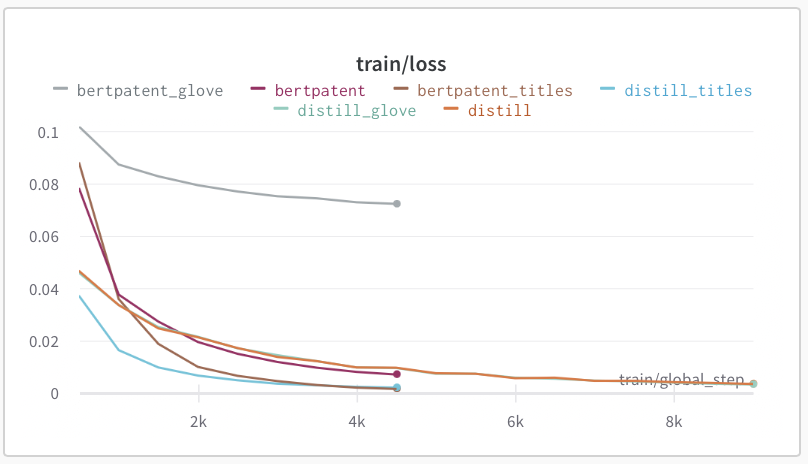

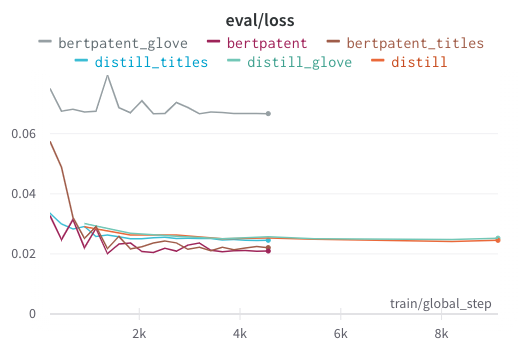

Due to the unknown error of the Wandb package, the experiments run on the CU Research Server are not fully recorded, but their losses do not change much in the end. <br>
It is notable that the loss for the bertpatent with glove information does not really go down eventually.

### Comparison of training runtime (in seconds)

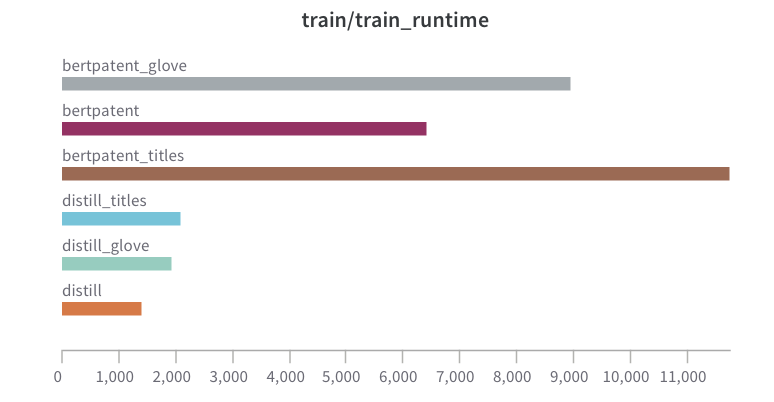

The distillbert and the berpatent are different in terms of speed largely.

## **Results and Discussion**
|       **Model**      | **Pearson score** |
|:--------------------:|-------------------|
| BERT-Patent          |      **0.84**     |
| BERT-Patent + GloVe  |        0.01       |
| BERT-Patent + Titles |        0.83       |
| distillBERT          |        0.81       |
| distillBERT + GloVe  |        0.80       |
| distillBERT + Titles |        0.80       |


We observe that BERT-Patent performs the best of all model configurations. Augmenting it with titles does not seem to help much. On the contrary, the predictive performance drops by one percentage point. When augmented with GloVe similarity scores, we saw an unexpectedly poor performance. Looking at the score and the corresponding loss curve (which is pretty flat from the outset and shows no signs of convergence), we believe that our fine-tuning for this configuration may need to be debugged in the future. 

As far as distillBERT is concerned, we see a similar theme. The best performance is achieved by the unaugmented distillBERT model whereas augmenting it with either GloVe similarity scores or CPC titles affects the performance negatively (only slightly, but a drop-off nonetheless).

It is noteworthy that despite competing with a model that is almost five times its size in terms of total parameters, distillBERT demonstrates an extremely competitive performance. The best distillBERT model achieves a score of 0.81, which is only 3 percentage points off the highest scoring model overall (BERT-Patent with no augmentation). This goes to show that we may be reaching a point of diminishing returns as the number of parameters increase. If performance is primary, BERT-Patent should be the first choice. However, if speed is more important to the user, distillBERT should be the obvious choice because it takes way less time for fine-tuning without a significant drop-off in performance. distillBERT is also a better choice when computational budgets are more limited.

## **Future Plan**

In [ ]:
class customModel(nn.Module):
    def __init__(self):
        super(customModel, self).__init__()
        
        config = AutoConfig.from_pretrained(CONFIG.model)
    
        self.bert = AutoModel.from_pretrained(CONFIG.model, config=config)
        self.drop = nn.Dropout(0.2)
        self.fc1 = nn.Linear(50,config.hidden_size)
        self.fc2 = nn.Linear(18,16)
        self.output = nn.Linear(config.hidden_size, 1)
        
    def forward(self, *inputs,anchor_glove,target_glove):
        ##Batch size is 16 in this case, and the max token length is also 16.

        ## We get the last hidden state from the bert output
        ## The size for the below x is batch_size * token_length * hidden_size (768 for distillbert and 1024 for Bert Patent)
        x = self.bert(*inputs).last_hidden_state


        ## We cancatnate the two glove embedding belove
        ## The size for glove is batch_size * 2 * 50
        glove = torch.cat((anchor_glove.unsqueeze(dim=1),
                           target_glove.unsqueeze(dim=1)),dim=1)
        

        ## After passing the first fully connected layer, the size is batch_size * 2 * hidden_size
        glove = self.fc1(glove)

        ## To concatenate the bert output and the glove embeddings
        ## The size will be batch_size * (token_length+2) * hidden_size
        x = torch.cat((x,glove),dim=1)

        ## Use the fully connected layer to convert it back to batch_size * token_length+2 *hidden_size
        x = x.reshape(16,-1,18)
        x = self.fc2(x)
        x = x.reshape(16,-1,1024)[:,0,:]
        x = self.output(x)

        return x 

The above architecture is what we will do for the next stage. <br>
Due to the limitation of time, we have not run and evaluate this model with the entire dataset, but we will do it in the future to achieve better results.<br>
This model instroduces the glove information in the middle of the process rather than introducing the glove tensor directly to the bert as inputs.

References:
1. https://www.kaggle.com/code/ksork6s4/uspppm-bert-for-patents-baseline-train